<a href="https://colab.research.google.com/github/21f1002963/MLT_WORKSHOP/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machines

We wil implement both hard-margin SVMs and soft-margin SVMs from scratch on a toy dataset. Apart from `NumPy`, we would need to take the help of `SciPy` for solving the quadratic programming problem.

## Hard-Margin SVM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 6]

In [ ]:
#### DATA: DO NOT EDIT THIS CELL ####
X = np.array([[1, -3], [1, 0], [4, 1], [3, 7], [0, -2],
             [-1, -6], [2, 5], [1, 2], [0, -1], [-1, -4],
             [0, 7], [1, 5], [-4, 4], [2, 9], [-2, 2],
             [-2, 0], [-3, -2], [-2, -4], [3, 10], [-3, -8]]).T
y = np.array([1, 1, 1, 1, 1,
             1, 1, 1, 1, 1,
             -1, -1, -1, -1, -1,
             -1, -1, -1, -1, -1])

### Understand the data

$\mathbf{X}$ is a data-matrix of shape $(d, n)$. $\mathbf{y}$ is a vector of labels of size $(n, )$. Specifically, look at the shapes of the arrays involved.

In [ ]:
d, n = X.shape

### Visualize the dataset

Visualize the dataset given to you using a scatter plot. Colour points which belong to class $+1$ $\color{green}{\text{green}}$ and those that belong to $-1$ $\color{red}{\text{red}}$. Inspect the data visually and determine its linear separability.

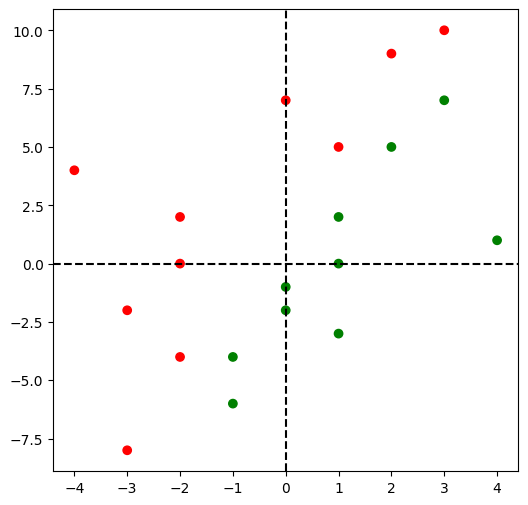

In [ ]:
colors = np.array(['', 'green', 'red'])
plt.scatter(X[0, :], X[1, :], c = colors[y])
plt.axhline(color = 'black', linestyle = '--')
plt.axvline(color = 'black', linestyle = '--')

### Linear Separability

Is there another way to determine linear separability?

In [ ]:
# Perceptron
w = np.zeros(d)
cycle = 0
while cycle < n:
    for i in range(n):
        # Prediction for the ith data-point
        if w @ X[:, i] >= 0:
            y_hat = 1
        else:
            y_hat = -1
        if y_hat != y[i]:
            cycle = 0
            w += X[:, i] * y[i]
        else:
            cycle += 1
w

array([14., -5.])

(-5.9735435477898715, 15.444414503587291, -15.4, 15.4)

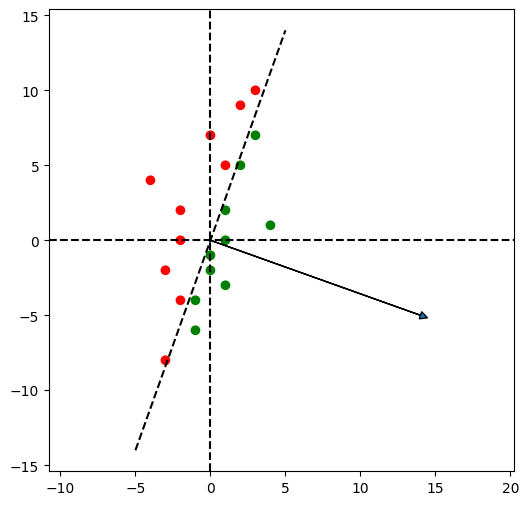

In [ ]:
colors = np.array(['', 'green', 'red'])
plt.scatter(X[0, :], X[1, :], c = colors[y])
plt.axhline(color = 'black', linestyle = '--')
plt.axvline(color = 'black', linestyle = '--')
plt.arrow(0, 0, w[0], w[1], head_width = 0.5, head_length = 0.5)
x = np.linspace(-5, 5)
plt.plot(x, -w[0] * x / w[1], linestyle = '--', color = 'black')
plt.axis('equal')

### Computing the Dual Objective

We shall follow a step-by-step approach to computing the dual objective function.

#### Step-1

Compute the object $\mathbf{Y}$ that appears in the dual problem.

In [ ]:
Y = np.diag(y)
Y

array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0

#### Step-2

Let $\boldsymbol{\alpha}$ be the dual variable. The dual objective is of the form:

$$
f(\boldsymbol{\alpha}) = \boldsymbol{\alpha}^T \mathbf{1} - \cfrac{1}{2} \cdot \boldsymbol{\alpha}^T \mathbf{Q} \boldsymbol{\alpha}
$$



Compute the matrix $\mathbf{Q}$ for this problem.

In [ ]:
Q = Y.T @ X.T @ X @ Y

#### Step-3

Since `SciPy`'s optimization routines take the form of minimizing a function, we will recast $f$ as follows:

$$
f(\boldsymbol{\alpha}) =  \cfrac{1}{2} \cdot \boldsymbol{\alpha}^T \mathbf{Q} \boldsymbol{\alpha} - \boldsymbol{\alpha}^T \mathbf{1}
$$

We now have to solve :

$$
\min \limits_{\boldsymbol{\alpha} \geq 0} \quad f(\boldsymbol{\alpha})
$$

Note that $\max$ changes to $\min$ since we changed the sign of the objective function.

In [ ]:
def f(alpha):
    return 0.5 * alpha.T @ Q @ alpha - alpha.sum()

### Optimize

Finally, we have most of the ingredients to solve the dual problem:

$$
\min \limits_{\boldsymbol{\alpha} \geq 0} \quad \cfrac{1}{2} \cdot \boldsymbol{\alpha}^T \mathbf{Q} \boldsymbol{\alpha} - \boldsymbol{\alpha}^T \mathbf{1}
$$

Find the optimal value, $\boldsymbol{\alpha^{*}}$.

In [ ]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [ ]:
res = minimize(f, np.zeros(n), bounds = Bounds(0, np.inf))
alpha_star = res.x
alpha_star

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.64285525, 1.65714065, 1.67142753, 1.68571355,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.71428422, 1.62856756])

### Support vectors

Find all the support vectors.

In [ ]:
X[:, alpha_star > 0]

array([[ 2,  1,  0, -1,  3, -3],
       [ 5,  2, -1, -4, 10, -8]])

### Optimal weight vector (Primal solution)

Find the optimal weight vector $\mathbf{w}^*$.

In [ ]:
w_star = X @ Y @ alpha_star
w_star

array([ 2.99998762, -1.00002588])

### Decision Boundary

Plot the decision boundary along with the supporting hyperplanes. Note where the support vectors lie in this plot.

(-10.0, 10.0)

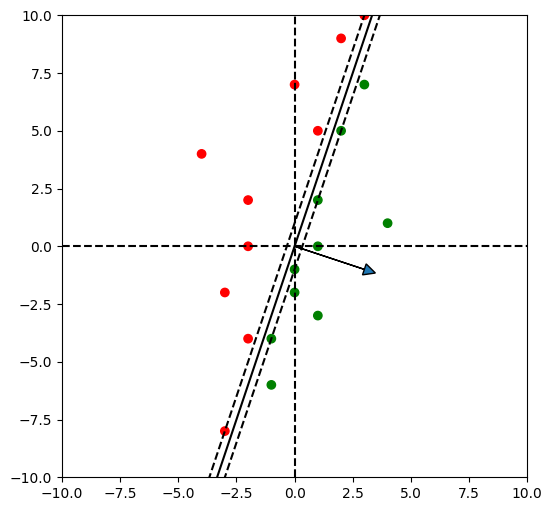

In [ ]:
colors = np.array(['', 'green', 'red'])
plt.scatter(X[0, :], X[1, :], c = colors[y])
plt.axhline(color = 'black', linestyle = '--')
plt.axvline(color = 'black', linestyle = '--')
plt.arrow(0, 0, w_star[0], w_star[1],
          head_width = 0.5, head_length = 0.5)
x = np.linspace(-5, 5)
plt.plot(x, -w_star[0] * x / w_star[1], color = 'black')
plt.plot(x, 1 / w_star[1] -w_star[0] * x / w_star[1], linestyle = '--', color = 'black')
plt.plot(x, -1/ w_star[1] -w_star[0] * x / w_star[1], linestyle = '--', color = 'black')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
#plt.axis('equal')

## Soft-margin SVM

We now turn to soft-margin SVMs. Adapt the hard-margin code that you have written for the soft-margin problem. The only change you have to make is to introduce an upper bound for $\boldsymbol{\alpha}$, which is the hyperparameter $C$.


In [ ]:
#### DATA: DO NOT EDIT THIS CELL ####
X = np.array([[1, -3], [1, 0], [4, 1], [3, 7], [0, -2],
             [-1, -6], [2, 5], [1, 2], [0, -1], [-1, -4],
             [0, 7], [1, 5], [-4, 4], [2, 9], [-2, 2],
             [-2, 0], [-3, -2], [-2, -4], [3, 10], [-3, -8],
             [0, 0], [2, 7]]).T
y = np.array([1, 1, 1, 1, 1,
             1, 1, 1, 1, 1,
             -1, -1, -1, -1, -1,
             -1, -1, -1, -1, -1,
              1, 1])

### Relationship between $C$ and margin

Plot the decision boundary and the supporting hyperplane for the following values of $C$.

(1) $C = 0.01$

(2) $C = 0.1$

(3) $C = 1$

(4) $C = 10$

Plot all of them in a $2 \times 2$ subplot. Study the tradeoff between the following quantities:

(1) Width of the margin.

(2) Number of points that lie within the margin or on the wrong side. This is often called **margin violation**.


In [ ]:
def train_SVM(X, y, C):
    d, n = X.shape
    Y = np.diag(y)
    Q = Y.T @ X.T @ X @ Y
    f = lambda alpha: 0.5 * alpha.T @ Q @ alpha - alpha.sum()
    res = minimize(f, x0 = np.zeros(n), bounds = Bounds(0, C))
    alpha_star = res.x
    w_star = X @ Y @ alpha_star
    return w_star, alpha_star

In [ ]:
def plot(X, y, w_star):
    colors = np.array(['', 'green', 'red'])
    plt.scatter(X[0, :], X[1, :], c = colors[y])
    plt.axhline(color = 'black', linestyle = '--')
    plt.axvline(color = 'black', linestyle = '--')
    plt.arrow(0, 0, w_star[0], w_star[1],
            head_width = 0.5, head_length = 0.5)
    x = np.linspace(-5, 5)
    plt.plot(x, -w_star[0] * x / w_star[1], color = 'black')
    plt.plot(x, 1 / w_star[1] -w_star[0] * x / w_star[1], linestyle = '--', color = 'black')
    plt.plot(x, -1/ w_star[1] -w_star[0] * x / w_star[1], linestyle = '--', color = 'black')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)

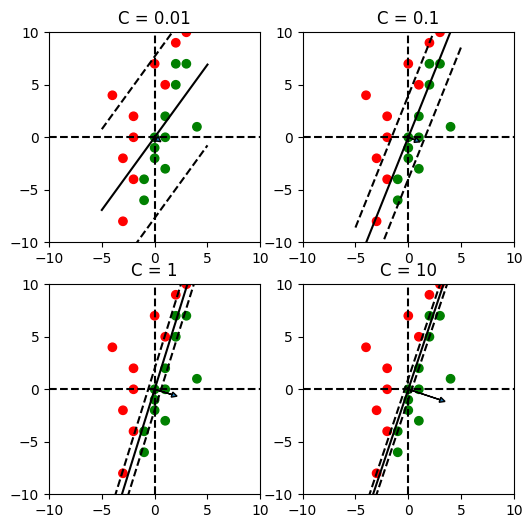

In [ ]:
for i, C in enumerate([0.01, 0.1, 1, 10]):
    w_star, alpha_star = train_SVM(X, y, C)
    plt.subplot(2, 2, i + 1)
    plot(X, y, w_star)
    plt.title(f'C = {C}')

### Support vectors

For $C = 10$, study the number of support vectors that the model has.

[[ 1.  0.]
 [ 2.  0.]
 [-1.  0.]
 [-2.  0.]]


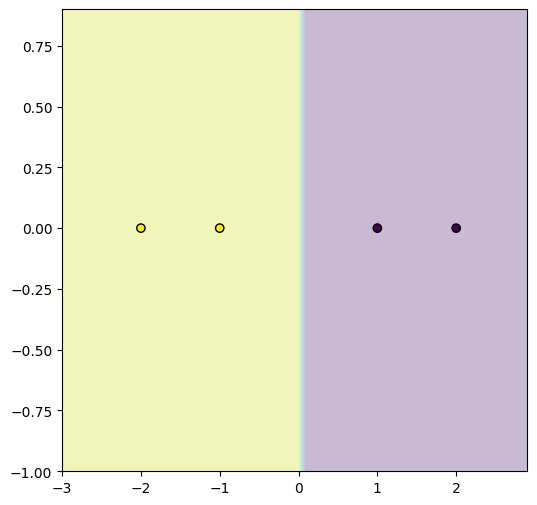

In [ ]:
import numpy as np
from sklearn.svm import SVC
X=np.array([[1, 0], [2, 0], [-1, 0], [-2, 0]])
y=np.array([0, 0, 1, 1])
clf=SVC()
clf.fit(X,y)
print(clf.support_vectors_)
# print(clf.support_)
# print(clf.n_support_)
clf.
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o')